# HDA - Project 3: TASK A
## Classification of Modes of Locomotion
This first cell contains the parameters that can be tuned for code execution:
- subject: select the subject on which to test the model, between [1,4];
- folder: directory name where '.mat' files are stored;
- label_col: column of features to be selected to perform activity detection, between [0,6];
- window_size: parameter that sets the length of temporal windows on which to perform the convolution;
- stride: step length to chose the next window.

In [1]:
subject = 1
folder = "./data/"
trim_zeros = True
label_col = 0     # default for task A
window_size = 15
stride = 15

In [2]:
import utils
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
make_binary = False

# import all sessions for a subject
(data1, data2, data3, data4, data5, data6) = utils.loadData(subject, folder=folder)

# create training set and test set
X_train = np.concatenate((data1['features_interp'],\
                          data2['features_interp'],\
                          data3['features_interp'],\
                          data6['features_interp']), axis=0)

Y_train = np.concatenate((data1['labels_cut'][:,label_col],\
                          data2['labels_cut'][:,label_col],\
                          data3['labels_cut'][:,label_col],\
                          data6['labels_cut'][:,label_col]), axis=0)

X_test = np.concatenate((data4['features_interp'],\
                         data5['features_interp']), axis=0)

Y_test = np.concatenate((data4['labels_cut'][:,label_col],\
                         data5['labels_cut'][:,label_col]))

features = X_test.shape[1]
print("\nTraining samples: ", X_train.shape[0],\
      "\nTest samples:      ", X_test.shape[0],\
      "\nFeatures:            ", features)


Session shapes:
ADL1:   (45810, 110)
ADL2:   (28996, 110)
ADL3:   (30167, 110)
ADL4:   (30228, 110)
ADL5:   (27308, 110)
Drill:  (52152, 110)

Training samples:  157125 
Test samples:       57536 
Features:             110


In [5]:
# decision to overcome the problem of entire missing columns
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

# features normalization
scaler = StandardScaler().fit(X_train)
X_train =scaler.transform(X_train)
X_test = scaler.transform(X_test)

# make the problem binary
if make_binary:
    Y_train[Y_train != 0] = 1
    Y_test[Y_test != 0] = 1

# switch to one hot encoded labels
onehot_encoder = OneHotEncoder(sparse=False)
Y_train_oh = onehot_encoder.fit_transform(Y_train.reshape(-1, 1))
Y_test_oh = onehot_encoder.fit_transform(Y_test.reshape(-1, 1))
print("\nClasses in training set: ", Y_train_oh.shape[1],\
      "\nClasses in test set:     ", Y_test_oh.shape[1])

print("Training set:")
X_train_s, Y_train_s = utils.prepareData(X_train, Y_train_oh, window_size, stride, shuffle=False)
print("\nTest set:")
X_test_s, Y_test_s = utils.prepareData(X_test, Y_test_oh, window_size, stride, shuffle=False)
# add bars plot


Classes in training set:  5 
Classes in test set:      5
Training set:

Features have shape:  (10474, 15, 110) 
Labels have shape:    (10474, 5) 
Fraction of labels:   [0.11075043 0.41789192 0.27592133 0.17099484 0.02444147]

Test set:

Features have shape:  (3834, 15, 110) 
Labels have shape:    (3834, 5) 
Fraction of labels:   [0.17736046 0.342723   0.20396453 0.23761085 0.03834116]


In [6]:
classes = np.max((Y_train_s.shape[1], Y_test_s.shape[1]))

model_unidim = utils.Model1D((window_size, features), classes)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 15, 18)            9918      
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 18)            72        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 15, 18)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 18)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 36)             4572      
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 36)             144       
___________________________________________________________

In [7]:
opt = Adam(lr=0.01)
model_unidim.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [8]:
model_unidim.fit(x = X_train_s, y = Y_train_s, epochs = 10, batch_size = 128, validation_data=(X_test_s, Y_test_s))

Train on 10474 samples, validate on 3834 samples
Epoch 1/10
10474/10474 [==============================] - 4s 352us/step - loss: 0.9166 - acc: 0.7757 - val_loss: 0.5678 - val_acc: 0.8365
Epoch 2/10
10474/10474 [==============================] - 3s 276us/step - loss: 0.4749 - acc: 0.8407 - val_loss: 0.4558 - val_acc: 0.8897
Epoch 3/10
10474/10474 [==============================] - 3s 258us/step - loss: 0.4214 - acc: 0.8554 - val_loss: 0.5292 - val_acc: 0.8610
Epoch 4/10
10474/10474 [==============================] - 3s 258us/step - loss: 0.4179 - acc: 0.8618 - val_loss: 0.4576 - val_acc: 0.8915
Epoch 5/10
10474/10474 [==============================] - 3s 258us/step - loss: 0.3871 - acc: 0.8737 - val_loss: 0.4701 - val_acc: 0.8688
Epoch 6/10
10474/10474 [==============================] - 3s 268us/step - loss: 0.3746 - acc: 0.8716 - val_loss: 0.4695 - val_acc: 0.8719
Epoch 7/10
10474/10474 [==============================] - 3s 257us/step - loss: 0.3607 - acc: 0.8843 - val_loss: 0.4081 - v

In [9]:
# predict labels
Y_pred_s = model_unidim.predict(X_test_s)

In [10]:
# print results
#reverse the one-ot encoder procedure
Y_test_hard = np.argmax(Y_test_s, axis=1)
Y_pred_hard = np.argmax(Y_pred_s, axis=1)

print("F1-measure: ", utils.f1_score(Y_test_hard, Y_pred_hard, average='weighted'))
print("AUC w.r. to each class: ", utils.AUC(Y_test_s, Y_pred_s, classes))

F1-measure:  0.904359293592176
AUC w.r. to each class:  {0: 0.9766957924577567, 1: 0.9844193182092725, 2: 0.9707614896776422, 3: 0.9997239802572655, 4: 0.8497893868694751}


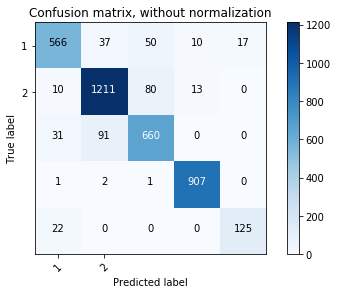

In [11]:
# Compute and plot confusion matrix
cnf_matrix = utils.confusion_matrix(Y_test_hard, Y_pred_hard)
np.set_printoptions(precision=2)

plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[1,2],
                      title='Confusion matrix, without normalization')